# Predict daily confirmed case increase in CA

In [91]:
import pandas as pd
import numpy as np
import datetime
import requests
import warnings
import pmdarima as pm
from statsmodels.tsa.statespace.sarimax import SARIMAX
from fbprophet import Prophet
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.preprocessing import StandardScaler
from xgboost import XGBRegressor
from keras.models import Sequential
from keras.layers import Dense
from keras.optimizers import Adam

warnings.filterwarnings('ignore')

In [2]:
#read the file
df = pd.read_csv('https://raw.githubusercontent.com/CSSEGISandData/COVID-19/master/csse_covid_19_data/csse_covid_19_time_series/time_series_covid19_confirmed_US.csv',
                usecols=np.r_[6,11:333])

In [3]:
df.head()

,Province_State,1/22/20,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,1/28/20,1/29/20,1/30/20,...,11/29/20,11/30/20,12/1/20,12/2/20,12/3/20,12/4/20,12/5/20,12/6/20,12/7/20,12/8/20
0,Alabama,0,0,0,0,0,0,0,0,0,...,2751,2780,2818,2873,2893,2945,2979,3005,3043,3087
1,Alabama,0,0,0,0,0,0,0,0,0,...,8820,8890,9051,9163,9341,9501,9626,9728,9821,9974
2,Alabama,0,0,0,0,0,0,0,0,0,...,1175,1178,1189,1206,1214,1217,1219,1223,1224,1240
3,Alabama,0,0,0,0,0,0,0,0,0,...,1188,1196,1204,1239,1252,1270,1283,1293,1299,1317
4,Alabama,0,0,0,0,0,0,0,0,0,...,2946,2997,3061,3100,3158,3231,3281,3299,3324,3426


In [4]:
#group by state 
df = df.groupby('Province_State').sum()

#add one row with the total amount of patients
df['Total'] = df.sum(axis=1)

#want delta not sum
df=df.diff(axis = 1).drop('1/22/20',axis = 1)

#set all negative value to zero
df[df < 0] = 0

df.tail()

,1/23/20,1/24/20,1/25/20,1/26/20,1/27/20,1/28/20,1/29/20,1/30/20,1/31/20,2/1/20,...,11/30/20,12/1/20,12/2/20,12/3/20,12/4/20,12/5/20,12/6/20,12/7/20,12/8/20,Total
Province_State,,,,,,,,,,,,,,,,,,,,,
Virginia,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,1893.0,2228.0,2417.0,2023.0,2877.0,3793.0,3880.0,3817.0,3860.0,25514082.0
Washington,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,2319.0,2197.0,3126.0,2095.0,1853.0,1503.0,1654.0,6957.0,2923.0,15818198.0
West Virginia,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,845.0,976.0,1087.0,1120.0,1147.0,1400.0,1425.0,1131.0,932.0,2965383.0
Wisconsin,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,2676.0,4635.0,4565.0,5604.0,5673.0,5711.0,3149.0,2322.0,4620.0,25643816.0
Wyoming,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,816.0,500.0,686.0,555.0,631.0,189.0,352.0,649.0,472.0,1599018.0


In [5]:
df.sort_values(by = 'Total',ascending = False, axis = 0, inplace = True)
df.head()
df5 = df.head().T.drop('Total')

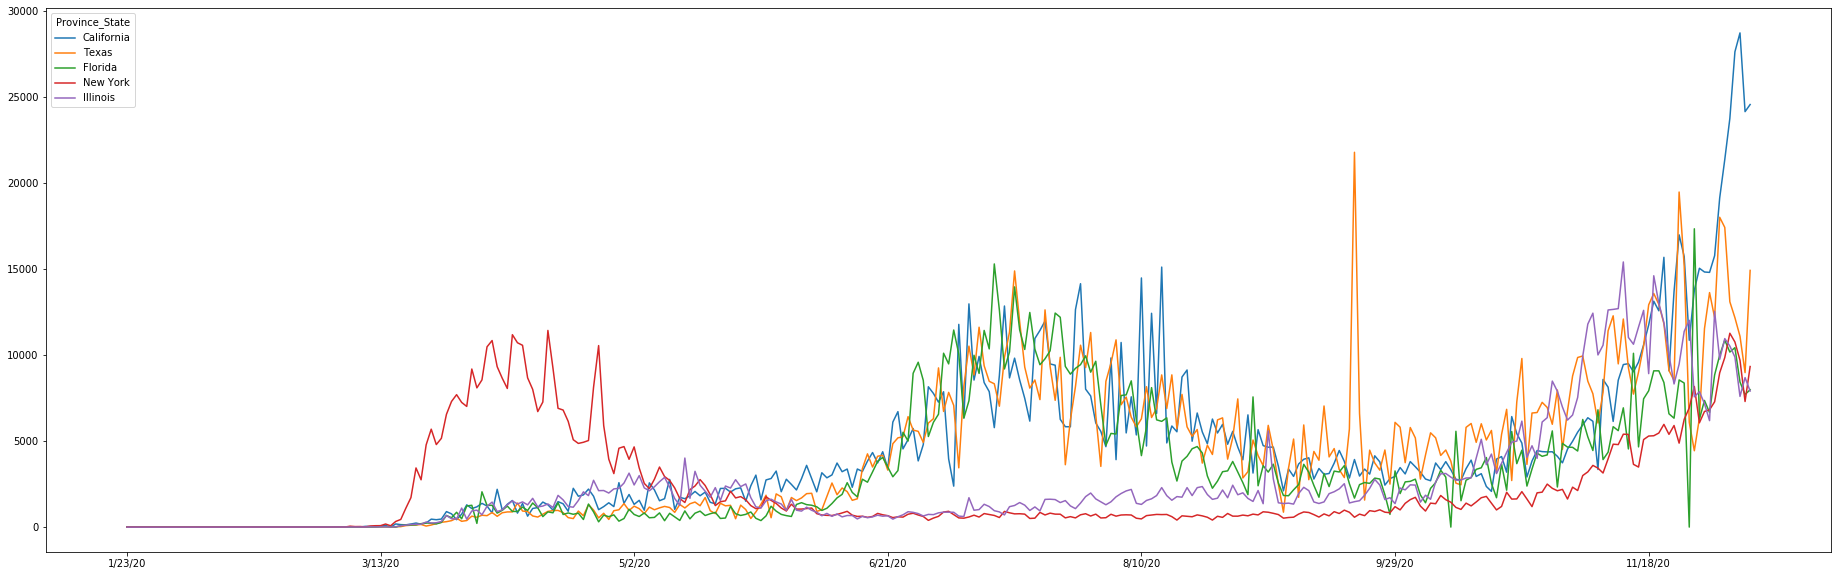

In [6]:
#plot NY and NJ to determine the timeframe 
df5.plot(kind='line',figsize=(32, 10))

In [7]:
CA = df.T['California']
CA = pd.DataFrame(CA)[:-1]

In [8]:
dataset = pd.DataFrame(columns = ['ds', 'y'])

In [9]:
dates = pd.to_datetime(CA.index)

In [10]:
CA

,California
1/23/20,0.0
1/24/20,0.0
1/25/20,0.0
1/26/20,2.0
1/27/20,0.0
...,...
12/4/20,23757.0
12/5/20,27634.0
12/6/20,28732.0
12/7/20,24155.0


In [21]:
dataset['ds'] = dates
dataset['y'] = CA['California'].values

In [38]:
dataset = dataset.set_index('ds')

In [39]:
dataset

,y
ds,
2020-01-23,0.0
2020-01-24,0.0
2020-01-25,0.0
2020-01-26,2.0
2020-01-27,0.0
...,...
2020-12-04,23757.0
2020-12-05,27634.0
2020-12-06,28732.0


In [40]:
train = dataset.loc[:'11/20/20']
test = dataset.loc['11/20/20':]

In [41]:
test.head()

,y
ds,
2020-11-20,12576.0
2020-11-21,15685.0
2020-11-22,9089.0
2020-11-23,13695.0
2020-11-24,16990.0


# SARIMAX

In [42]:
model = pm.auto_arima(train, start_p=1, start_q=1,
                      test='adf',       # use adftest to find optimal 'd'
                      max_p=3, max_q=3,  # maximum p and q
                      m=1,              # frequency of series
                      d=None,           # let model determine 'd'
                      seasonal=False,   # No Seasonality
                      start_P=0,
                      D=0,
                      trace=True,
                      error_action='ignore',
                      suppress_warnings=True,
                      stepwise=True)

print(model.summary())

Performing stepwise search to minimize aic
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=5296.711, Time=0.18 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=5452.347, Time=0.01 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=5313.892, Time=0.03 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=5298.299, Time=0.14 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=5450.480, Time=0.01 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=5288.502, Time=0.24 sec
 ARIMA(2,1,0)(0,0,0)[0] intercept   : AIC=5314.967, Time=0.03 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=5269.782, Time=0.23 sec
 ARIMA(3,1,0)(0,0,0)[0] intercept   : AIC=5288.772, Time=0.05 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=5271.803, Time=0.39 sec
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=5274.028, Time=0.29 sec
 ARIMA(3,1,1)(0,0,0)[0]             : AIC=5270.895, Time=0.06 sec

Best model:  ARIMA(3,1,1)(0,0,0)[0] intercept
Total fit time: 1.683 seconds
                               SARIMAX Results                                
Dep. Vari

In [43]:
model = SARIMAX(train, order = (3,1,1))

/Users/wjq/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)
/Users/wjq/opt/anaconda3/lib/python3.7/site-packages/statsmodels/tsa/base/tsa_model.py:162: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  % freq, ValueWarning)


In [44]:
results= model.fit(disp = True)

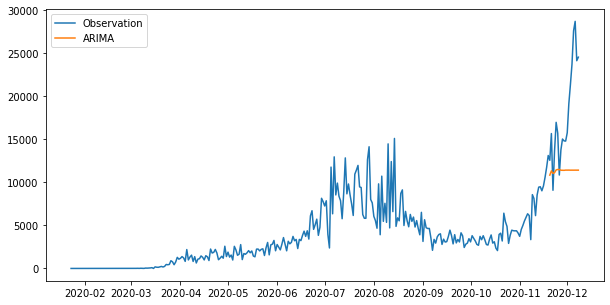

In [45]:
sarimax_prediction = results.predict(
    start = '2020-11-20', end = '2020-12-08', dynamic = False)
plt.figure(figsize = (10,5))
l1, = plt.plot(dataset, label = 'Observation')
l2, = plt.plot(sarimax_prediction, label = 'ARIMA')
plt.legend(handles=[l1,l2])
plt.savefig('SARIMAX prediction', bbox_inches='tight',transparent=False)

In [46]:
print('SARIMAX MAE =', mean_absolute_error(sarimax_prediction, test))

SARIMAX MAE = 6708.201088377563


# Prophet 

In [47]:
train['ds'] = train.index.values

/Users/wjq/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [48]:
train

,y,ds
ds,,
2020-01-23,0.0,2020-01-23
2020-01-24,0.0,2020-01-24
2020-01-25,0.0,2020-01-25
2020-01-26,2.0,2020-01-26
2020-01-27,0.0,2020-01-27
...,...,...
2020-11-16,9595.0,2020-11-16
2020-11-17,10595.0,2020-11-17
2020-11-18,11755.0,2020-11-18


In [49]:
m = Prophet(yearly_seasonality=True,daily_seasonality=True)
m.fit(train)

In [50]:
future = m.make_future_dataframe(periods = CA.shape[0]-train.shape[0])
prophet_prediction = m.predict(future)

In [51]:
prophet_prediction = prophet_prediction.set_index('ds')
prophet_future = prophet_prediction.yhat.loc[prophet_prediction.index>= '2020-11-20']
print('Prophet MAE =', mean_absolute_error(prophet_future,test))

Prophet MAE = 4457.907837746798


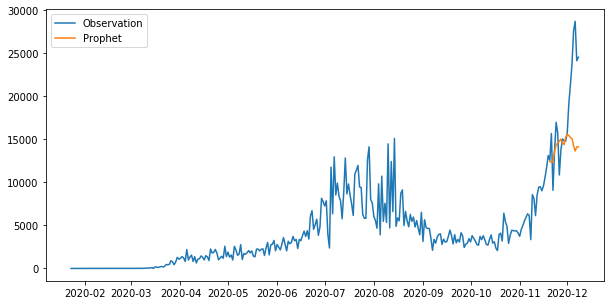

In [54]:
plt.figure(figsize =(10,5))
l1, = plt.plot(dataset, label='Observation')
l2, = plt.plot(prophet_future, label='Prophet')
plt.legend(handles=[l1,l2])
plt.savefig('Prophet predictions',
           bbox_inches='tight',transparent=False)

# XGBoost

In [67]:
def featurize(t):
    X = pd.DataFrame()
    X['day'] = t.index.day
    X['month'] = t.index.month
    X['quarter'] = t.index.quarter
    X['dayofweek'] = t.index.dayofweek
    X['dayofyear'] = t.index.dayofyear
    y = t.y
    return X,y

In [68]:
X_train, y_train = featurize(dataset.loc[:'11/20/20'])
X_test, y_test = featurize(dataset.loc['11/20/20':])

In [69]:
scaler = StandardScaler().fit(X_train)
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [79]:
XGBOOST_model = XGBRegressor(n_estimators = 7,objective="reg:squarederror")

In [80]:
XGBOOST_model.fit(X_train_scaled, y_train,
                 eval_set = [(X_train_scaled,y_train),(X_test_scaled,y_test)],
                 verbose = True)
XGBOOST_prediction = XGBOOST_model.predict(X_test_scaled)

[0]	validation_0-rmse:4459.48	validation_1-rmse:17774.1
[1]	validation_0-rmse:4073.25	validation_1-rmse:16999
[2]	validation_0-rmse:3728.48	validation_1-rmse:16299.1
[3]	validation_0-rmse:3420.91	validation_1-rmse:15667
[4]	validation_0-rmse:3146.28	validation_1-rmse:15051.1
[5]	validation_0-rmse:2899.94	validation_1-rmse:14532.1
[6]	validation_0-rmse:2678.95	validation_1-rmse:14101.5


In [81]:
print('XGBOOST MAE =', mean_absolute_error(XGBOOST_prediction,y_test))

XGBOOST MAE = 12982.944027549342


In [86]:
XGBOOST_df = pd.DataFrame({'y':XGBOOST_prediction.tolist()})
XGBOOST_df.index = y_test.index

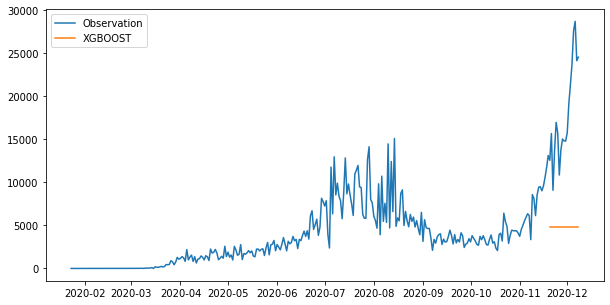

In [88]:
plt.figure(figsize =(10,5))
l1, = plt.plot(dataset, label='Observation')
l2, = plt.plot(XGBOOST_df, label='XGBOOST')
plt.legend(handles=[l1,l2])
plt.savefig('XGBOOST Predictions',
           bbox_inches='tight',transparent=False)

# Neural Network

In [94]:
NN = Sequential()
NN.add(Dense(20, input_shape=(X_train_scaled.shape[1],)))
NN.add(Dense(10))
NN.add(Dense(1))
NN.compile(loss='mean_absolute_error',optimizer = Adam(lr=0.001))
NN.fit(X_train_scaled,y_train,validation_data=(X_test_scaled,y_test),
      epochs=220,verbose=1)
NN_prediction = NN.predict(X_test_scaled)

Epoch 1/220
10/10 [==============================] - 0s 12ms/step - loss: 3596.5239 - val_loss: 17800.5059
Epoch 2/220
10/10 [==============================] - 0s 2ms/step - loss: 3596.4395 - val_loss: 17800.2578
Epoch 3/220
10/10 [==============================] - 0s 3ms/step - loss: 3596.3623 - val_loss: 17799.9434
Epoch 4/220
10/10 [==============================] - 0s 2ms/step - loss: 3596.2739 - val_loss: 17799.8184
Epoch 5/220
10/10 [==============================] - 0s 3ms/step - loss: 3596.1824 - val_loss: 17799.6289
Epoch 6/220
10/10 [==============================] - 0s 3ms/step - loss: 3596.0789 - val_loss: 17799.3379
Epoch 7/220
10/10 [==============================] - 0s 3ms/step - loss: 3595.9517 - val_loss: 17799.0645
Epoch 8/220
10/10 [==============================] - 0s 3ms/step - loss: 3595.8027 - val_loss: 17798.6660
Epoch 9/220
10/10 [==============================] - 0s 3ms/step - loss: 3595.6226 - val_loss: 17798.1543
Epoch 10/220
10/10 [=========================

10/10 [==============================] - 0s 3ms/step - loss: 2933.5054 - val_loss: 16249.2061
Epoch 78/220
10/10 [==============================] - 0s 2ms/step - loss: 2907.4900 - val_loss: 16184.3418
Epoch 79/220
10/10 [==============================] - 0s 3ms/step - loss: 2880.5212 - val_loss: 16113.3779
Epoch 80/220
10/10 [==============================] - 0s 3ms/step - loss: 2852.5737 - val_loss: 16053.2617
Epoch 81/220
10/10 [==============================] - 0s 2ms/step - loss: 2824.6033 - val_loss: 15986.2236
Epoch 82/220
10/10 [==============================] - 0s 2ms/step - loss: 2795.5796 - val_loss: 15920.2764
Epoch 83/220
10/10 [==============================] - 0s 2ms/step - loss: 2765.6184 - val_loss: 15852.0625
Epoch 84/220
10/10 [==============================] - 0s 3ms/step - loss: 2736.2573 - val_loss: 15773.5391
Epoch 85/220
10/10 [==============================] - 0s 2ms/step - loss: 2704.5383 - val_loss: 15699.5498
Epoch 86/220
10/10 [==============================

10/10 [==============================] - 0s 2ms/step - loss: 1592.6672 - val_loss: 11855.0068
Epoch 154/220
10/10 [==============================] - 0s 3ms/step - loss: 1591.4585 - val_loss: 11838.3174
Epoch 155/220
10/10 [==============================] - 0s 3ms/step - loss: 1590.5114 - val_loss: 11832.5742
Epoch 156/220
10/10 [==============================] - 0s 3ms/step - loss: 1589.3387 - val_loss: 11833.7861
Epoch 157/220
10/10 [==============================] - 0s 3ms/step - loss: 1588.7374 - val_loss: 11822.3057
Epoch 158/220
10/10 [==============================] - 0s 3ms/step - loss: 1587.7410 - val_loss: 11811.3945
Epoch 159/220
10/10 [==============================] - 0s 4ms/step - loss: 1586.9568 - val_loss: 11805.5986
Epoch 160/220
10/10 [==============================] - 0s 4ms/step - loss: 1586.3860 - val_loss: 11781.4424
Epoch 161/220
10/10 [==============================] - 0s 3ms/step - loss: 1585.4520 - val_loss: 11771.9551
Epoch 162/220
10/10 [=====================

In [95]:
print('NN MAE =', mean_absolute_error(NN_prediction,y_test))

NN MAE = 11362.735865542763


In [100]:
NN_df = pd.DataFrame(NN_prediction)
NN_df.index = y_test.index

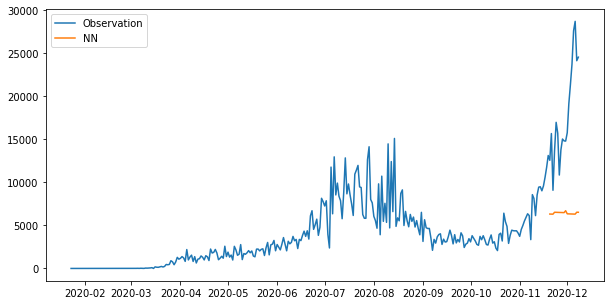

In [101]:
plt.figure(figsize =(10,5))
l1, = plt.plot(dataset, label='Observation')
l2, = plt.plot(NN_df, label='NN')
plt.legend(handles=[l1,l2])
plt.savefig('NN Predictions',
           bbox_inches='tight',transparent=False)

<Figure size 2880x2880 with 0 Axes>

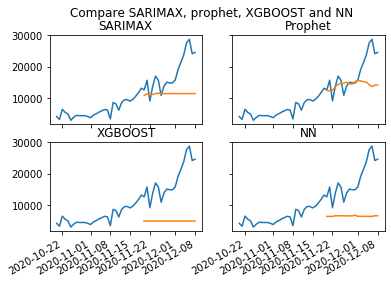

In [106]:
plt.figure(figsize=(40,40))
fig,axs = plt.subplots(2,2)
fig.suptitle('Compare SARIMAX, prophet, XGBOOST and NN')
axs[0,0].plot(dataset.tail(50))
axs[0,0].plot(sarimax_prediction.tail(50))
axs[0,0].set_title('SARIMAX')
axs[0,1].plot(dataset.tail(50))
axs[0,1].plot(prophet_future.tail(50))
axs[0,1].set_title('Prophet')
axs[1,0].plot(dataset.tail(50))
axs[1,0].plot(XGBOOST_df.tail(50))
axs[1,0].set_title('XGBOOST')
axs[1,1].plot(dataset.tail(50))
axs[1,1].plot(NN_df.tail(50))
axs[1,1].set_title('NN')

for ax in fig.get_axes():
    ax.label_outer()
fig.autofmt_xdate()

plt.savefig('Comparison',bbox_inches='tight',transparent=False)